In [236]:
!pip install pyarrow
!pip install plotly
!pip install orion
!pip install tqdm
!pip install pandarallel
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 6.2 MB/s eta 0:00:0000:01


# Process operating data

In [14]:
import pandas as pd

operating_data_df =  pd.read_parquet('operating_data.parquet.gzip')
operating_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23236237 entries, 0 to 23236236
Data columns (total 6 columns):
 #   Column        Dtype         
---  ------        -----         
 0   date          datetime64[ns]
 1   datatype      category      
 2   country       category      
 3   bidding_area  category      
 4   code          category      
 5   value         float32       
dtypes: category(4), datetime64[ns](1), float32(1)
memory usage: 354.6 MB


In [ ]:
import plotly.express as px
from plotly.subplots import make_subplots

swedish_wind = operating_data_df[(operating_data_df.country=='Sweden') & (operating_data_df.code=='WS')]
sweden_bedding_areas = swedish_wind.bidding_area.unique()
fig = make_subplots(rows=len(sweden_bedding_areas), cols=1,
                    subplot_titles=sweden_bedding_areas)
for i, area in enumerate(sweden_bedding_areas):
    df = swedish_wind[swedish_wind.bidding_area==area].sort_values(by=['date'])
    fig.add_trace(
        px.line(df, x='date', y='value').data[0],
        row=i+1, col=1
    )
fig.update_layout(height=900, width=1400, title_text="Wind gen in Sweden")
fig.show()

In [12]:
operating_data_wide = operating_data_df.pivot(index=['date','datatype', 'country', 'bidding_area'], columns='code', values='value')
operating_data_wide = operating_data_wide.reset_index()

In [69]:
def plot_operating_data_by_country(df, code, name, as_jpeg=False):
    mask1 = df[code].isnull()
    mask2 = df['bidding_area'].isin(['Sverige', 'Norge', 'Denmark', 'Finland', 'Estonia', 'Lativa', 'Lithuania'])
    consumption = df[~mask1 & mask2]
    consumption = consumption.groupby(['country', 'bidding_area']).resample('W', on='date').mean(numeric_only=True).reset_index()
    consumption.country = consumption.country.astype('object')
    fig = px.line(consumption, x='date', y=code, color='country', title=f'{name} by country')
    fig.update_traces(marker_size=2)
    fig.update_layout(legend= {'itemsizing': 'constant'})
    if as_jpeg:
        fig.show(renderer="jpeg", width=1400, height=500)
    else:
        fig.show()

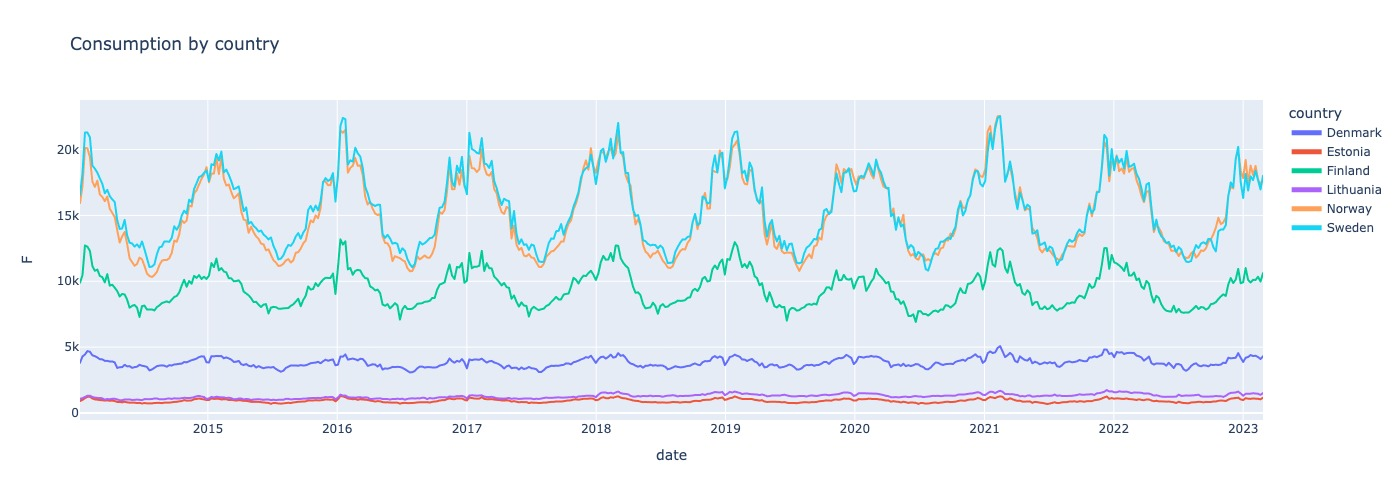

In [70]:
plot_operating_data_by_country(operating_data_wide, 'F', 'Consumption', as_jpeg=True)

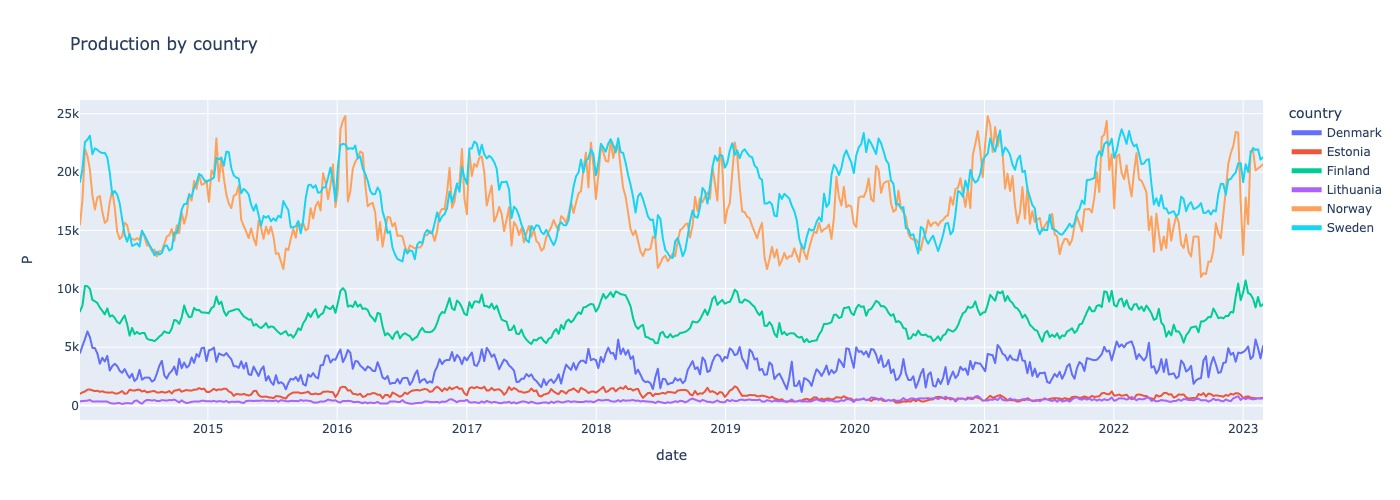

In [71]:
plot_operating_data_by_country(operating_data_wide, 'P', 'Production', as_jpeg=True)

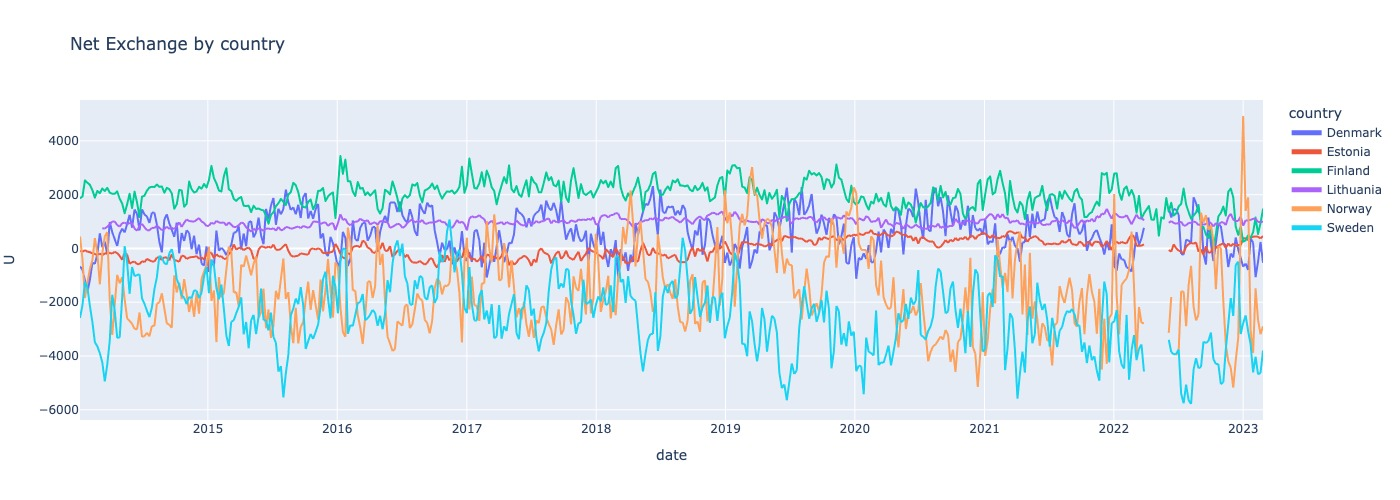

In [72]:
plot_operating_data_by_country(operating_data_wide, 'U', 'Net Exchange', as_jpeg=True)

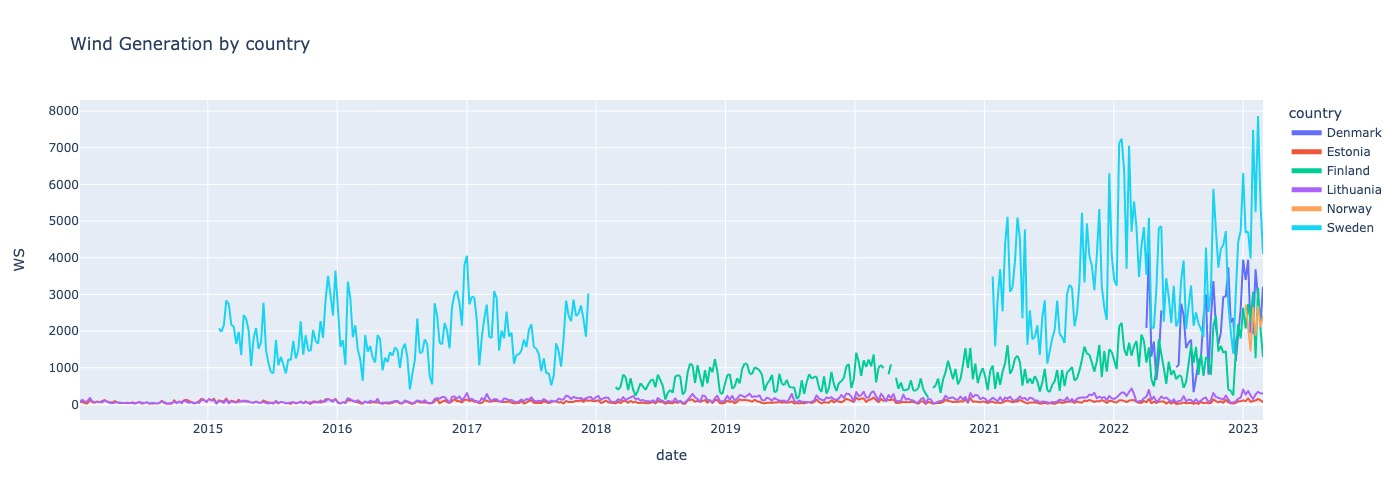

In [73]:
plot_operating_data_by_country(operating_data_wide, 'WS', 'Wind Generation', as_jpeg=True)

# Process price data

In [26]:
prices_df = pd.read_parquet('spot_prices.parquet.gzip')
prices_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1298304 entries, 0 to 1467710
Data columns (total 4 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   country        1298304 non-null  category      
 1   bidding_area   973728 non-null   category      
 2   date           1298304 non-null  datetime64[ns]
 3   price_eur_mwh  1298304 non-null  float32       
dtypes: category(2), datetime64[ns](1), float32(1)
memory usage: 27.2 MB


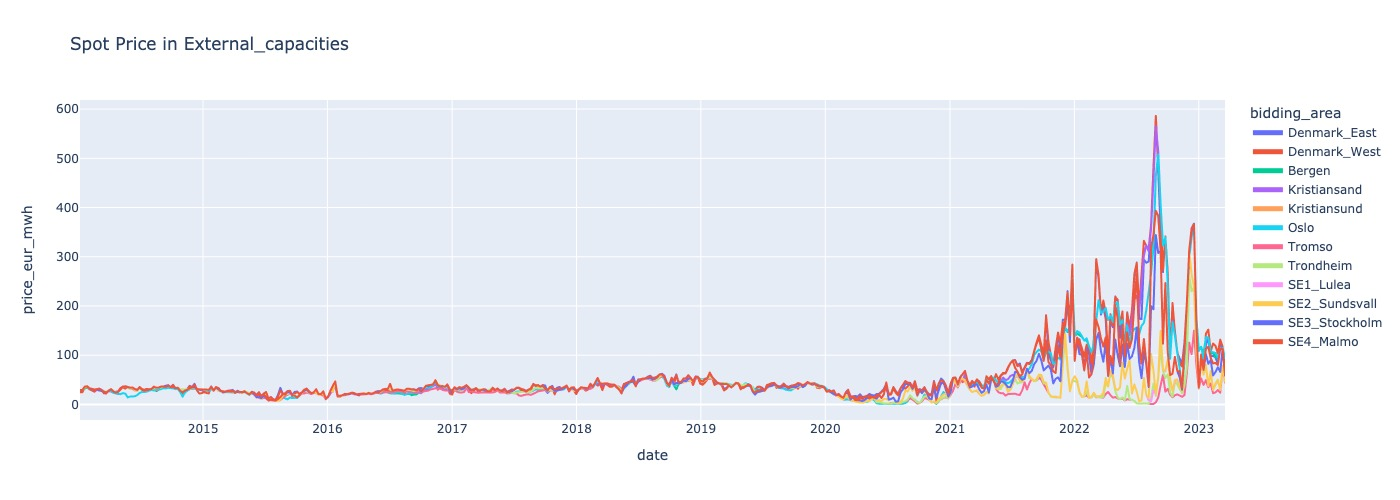

In [78]:
prices = prices_df.groupby(['country', 'bidding_area']).resample('W', on='date').mean(numeric_only=True).reset_index()
prices.bidding_area = prices.bidding_area.astype('object')
fig = px.line(prices, x='date', y='price_eur_mwh', color='bidding_area', title=f'Spot Price by bidding area')
fig.update_layout(legend= {'itemsizing': 'constant'})
fig.update_traces(marker_size=2)
fig.show(renderer="jpeg", width=1400, height=500)

In [79]:
pd.options.mode.chained_assignment = None  # default='warn'

def plot_prices_by_country(df, country, as_jpeg=False):
    prices = df[df.country == country]
    prices.bidding_area = prices.bidding_area.astype('object')
    prices = prices.groupby(['country', 'bidding_area']).resample('W', on='date').mean(numeric_only=True).reset_index()
    fig = px.line(prices, x='date', y='price_eur_mwh', color='bidding_area', title=f'Spot Price in {country}')
    fig.update_layout(legend= {'itemsizing': 'constant'})
    fig.update_traces(marker_size=2)
    if as_jpeg:
        fig.show(renderer="jpeg", width=1400, height=500)
    else:
        fig.show()

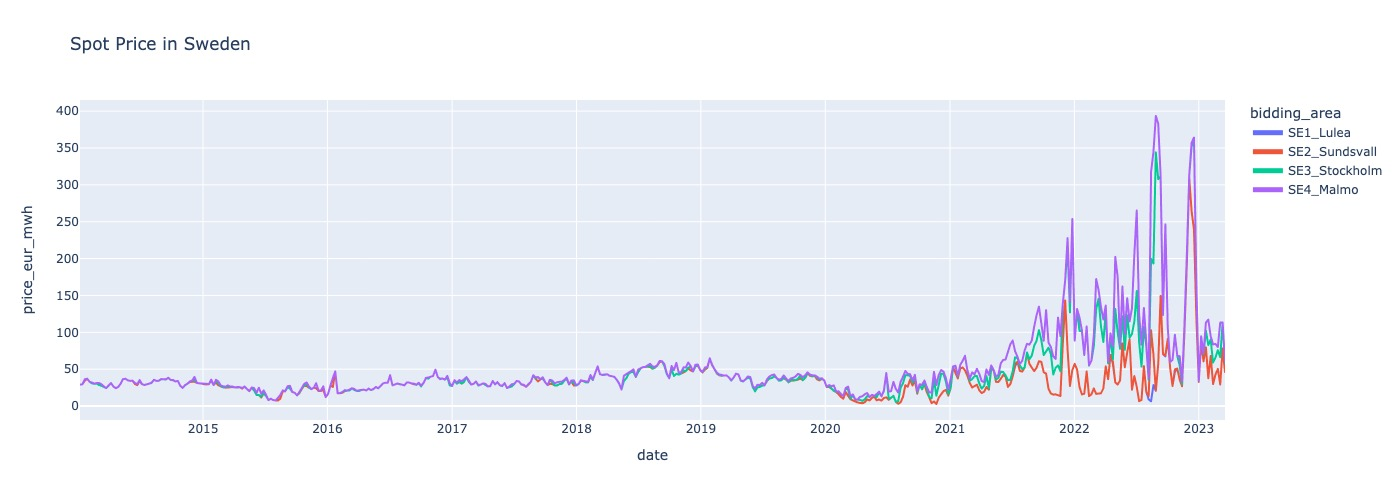

In [80]:
plot_prices_by_country(prices_df, 'Sweden', as_jpeg=True)

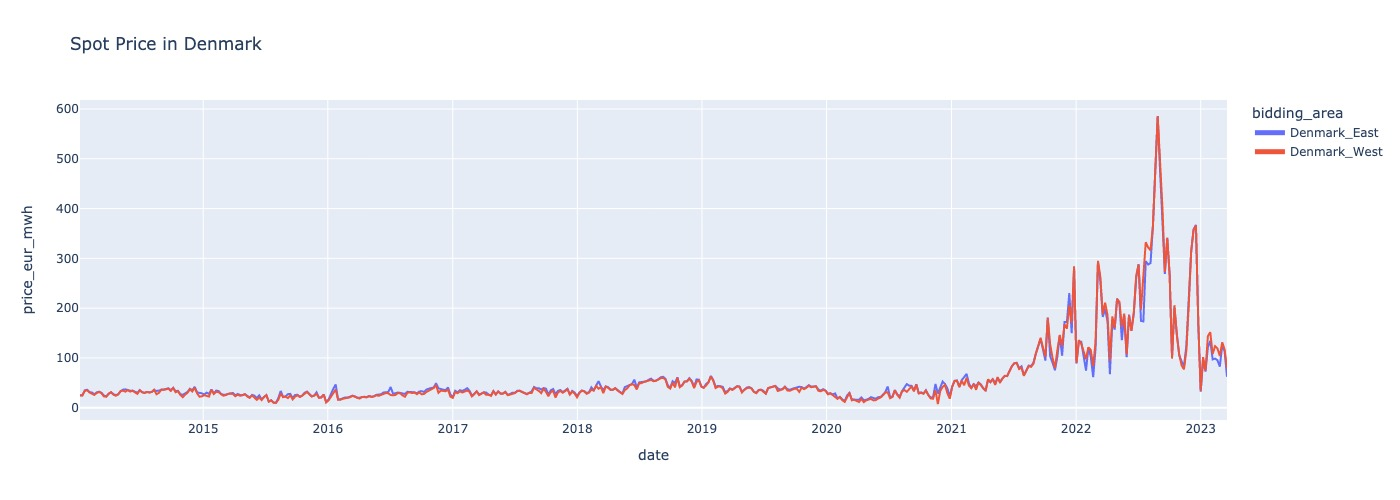

In [81]:
plot_prices_by_country(prices_df, 'Denmark', as_jpeg=True)

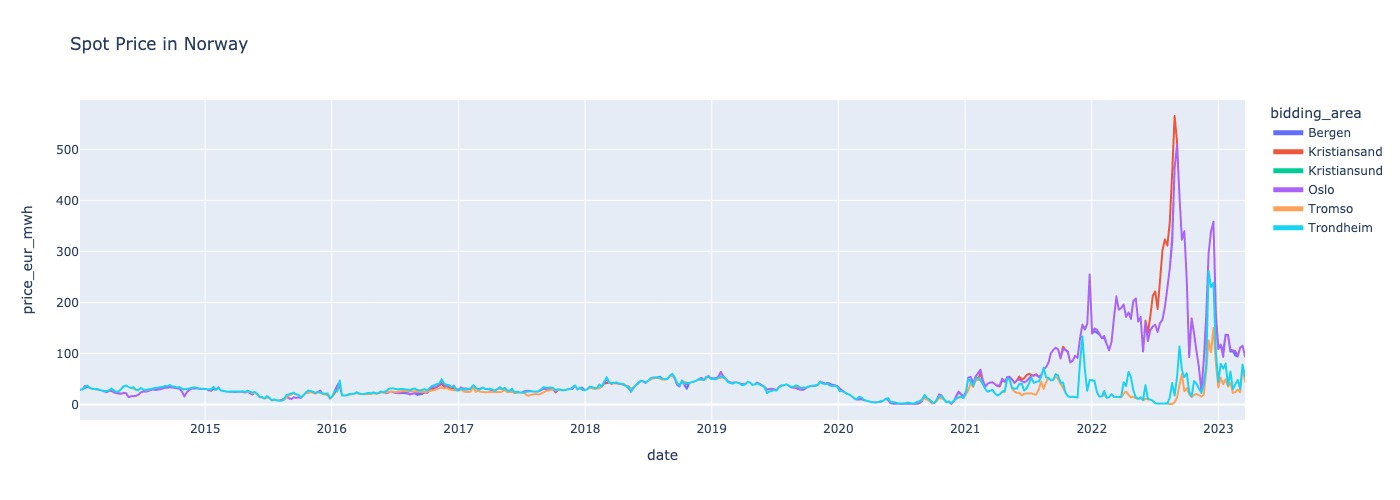

In [82]:
plot_prices_by_country(prices_df, 'Norway', as_jpeg=True)

# Correlation

In [ ]:
prices_df.to_parquet('spot_prises.parquet.gzip',compression='gzip')
prices_df

In [ ]:
import plotly.express as px

bergen_df = prices_df[prices_df['bidding_area']=='Bergen'].sort_values(by=['date']).reset_index(drop=True)
fig = px.scatter(bergen_df, x='date', y='price_eur_mwh', color='country')
fig.show()

Estimated number of clusters: 1


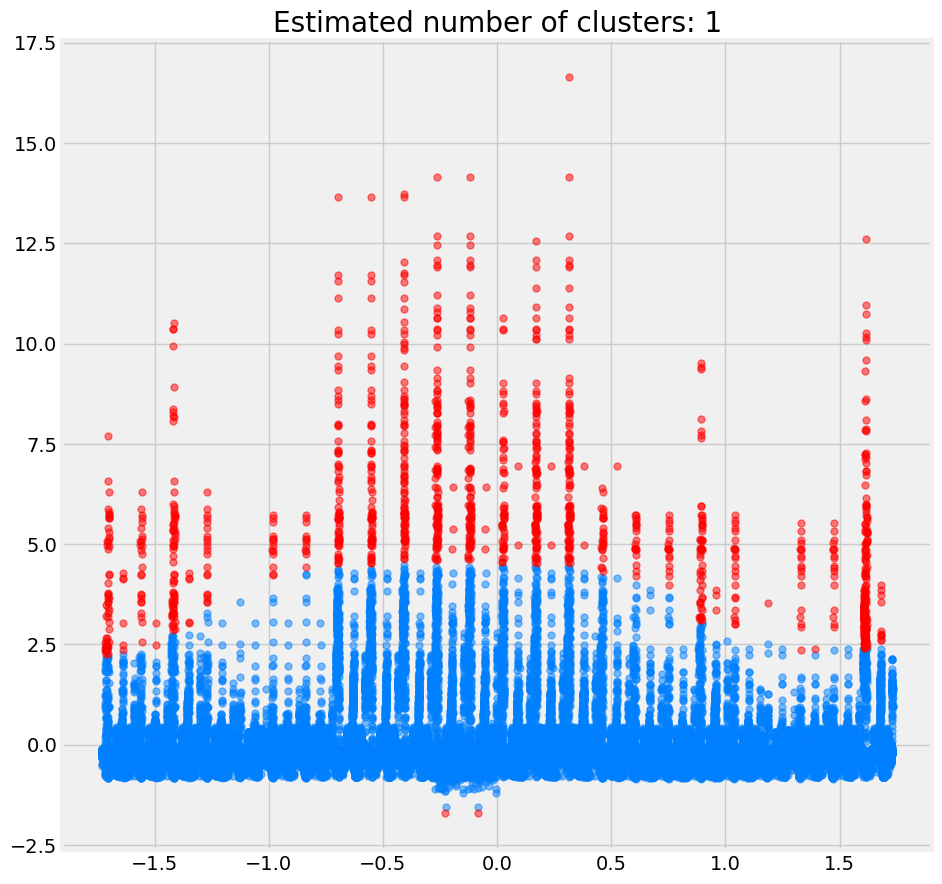

In [21]:
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
plt.style.use('fivethirtyeight')

X = [[i, prices_df['price_eur_mwh'][i]]  for i in range(len(bergen_df))]
X = StandardScaler().fit_transform(X)
db = DBSCAN(eps=0.5, min_samples=200).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)

unique_labels = set(labels)
plt.figure(num=None, figsize=(10, 10), facecolor='w', edgecolor='k')
for k in unique_labels:
    col=[0,0.5,1,1]
    if k == -1:
        col = [1, 0, 0, 1]
    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', color=tuple(col),markersize=5, alpha=0.5)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', color=tuple(col), markersize=5, alpha=0.5)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

# Process weather data

In [46]:
import os
import pandas as pd

df = pd.read_csv('city_temperature.csv', sep=',', decimal='.')

/var/folders/l_/yszbrvm96clcdwdldb5h3gmr0000gn/T/ipykernel_16275/1989910942.py:4: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('city_temperature.csv', sep=',', decimal='.')


In [49]:
df[df['Country']=='Denmark']['City'].unique()


array(['Copenhagen'], dtype=object)